## Installments and Imports

In [2]:
# Uncomment if necessary!
!pip install -r requirements.txt
!pip install eep153_tools

In [3]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cfe

Missing dependencies for OracleDemands.


## Acquire DataFrames



In [4]:
# Taken from the Steps notebook
# Load Philippines data (Bukidnon 2003)
sheet = '1z35Kyga40hhoGBEQIY9jReY6z1wmnsnlUVw-pFEaBhg'

InputFiles = {'Expenditures':(sheet,'Expenditures'),
              'Consumption':(sheet,'Quantities'),
              'HH Characteristics':(sheet,'HH Characteristics'),
              'FCT':(sheet,'FCT')}

In [5]:
# Clean data
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


## Estimate Demand System



In [6]:
result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

# Uncomment to check the beta values
# result.get_beta(as_df=True).sort_values(ascending=False) 

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (2003, 'Bukidnon')
  warnings.warn("No variation in: %s" % str(constant))


## Infer prices



In [7]:
# xhat is an xarray; change to df
xhatdf = xhat.to_dataset('i').to_dataframe()
xhatdf.columns.name ='i'

phat = xhatdf/q

# Keep gram unit
phat = phat.xs('g',level='u').groupby(['t','m']).median().T.dropna(how='all')
result['prices'] = phat.stack().to_xarray().to_array()

# Make this persistent...
result.to_dataset('./BUK-.ds')

<xarray.Dataset>
Dimensions:           (j: 572, i: 42, k: 19, variable: 1, m: 1, t: 1, kp: 19)
Coordinates:
  * j                 (j) int64 2 4 5 6 12 13 14 ... 935 936 937 938 939 940 941
  * t                 (t) int64 2003
  * m                 (m) object 'Bukidnon'
  * i                 (i) object 'Alcoholic drinks' 'Ampalaya' ... 'Vinegar'
  * k                 (k) <U14 'Males 0-1' 'Males 1-5' ... 'log HSize'
  * kp                (kp) <U14 'Males 0-1' 'Males 1-5' ... 'log HSize'
  * variable          (variable) int64 2003
Data variables: (12/20)
    alpha             object None
    beta              (i) float64 0.3504 0.4552 0.5287 ... 0.4953 0.3081 0.2475
    delta             (k, i) float64 0.1977 0.04092 0.2227 ... -0.163 0.1419
    prices            (variable, i, m) float64 0.05876 0.02122 ... 0.2164
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.792 1.386 1.099
    loglambdas        (j, t, m) float64 -0.3177 -1.481 1.001 ... -1.071 -1.366
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              (i, t, m) float64 0.05653 0.05677 ... 0.03243 0.03187
    y                 (i, j, t, m) float64 nan nan 3.091 ... -0.6931 1.946 2.996
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 1.792 1.386 1.099

## Compute Demand

In [8]:
# Taken from Example_demands notebook
t = result.firstround  # First round
m = result.coords['m'][0] # First market

x = result.get_predicted_expenditures().sum('i')
x = x.where(x>0).sel(t=t,m=m).median('j') # Budget (median household)`

# Note selection of prices for 1975 for market A
p = result.prices.sel(m=m).fillna(1).copy()
p_series = p.to_dataframe().fillna(1).squeeze().loc[2003,:]['prices']

# Compute demand
c=result.demands(x,p)
c_series = c.loc[:,2003]

Text(0, 0.5, 'Price')

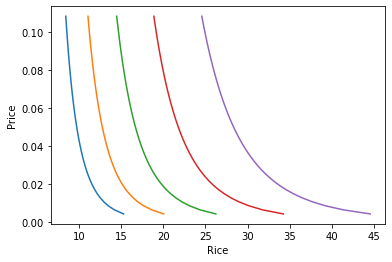

In [9]:
# Trace a demand curve
%matplotlib inline

USE = 'BUK'
USE_GOOD = 'Rice'
    
# Values for prices
# ref_price = result.prices.sel(i=USE_GOOD,m=m)
ref_price = p_series[USE_GOOD]
P = np.linspace(ref_price/5,ref_price*5,50)

def my_prices(p0,p=p_series,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p

for myx in [x*s for s in [.25,.5,1.,2,4]]:
    plt.plot([result.demands(myx,my_prices(p0))[USE_GOOD] for p0 in P],P)

plt.xlabel(USE_GOOD)
plt.ylabel('Price')

## Predicting Positive Consumption



/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (2003, 'Bukidnon')
  warnings.warn("No variation in: %s" % str(constant))


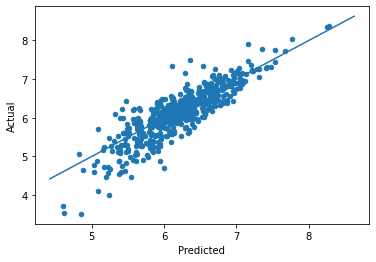

In [10]:
%matplotlib inline

zeros_r = cfe.Result(y=(0.+(np.exp(result.y)>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

## Get predicted quantities



In [11]:
# Put predictions into a dataframe
xhatdf = xhat.to_dataset('i').to_dataframe()
xhatdf.columns.name ='i'

qhat = xhatdf.div(phat.T,axis=1)

qhat

i                  Alcoholic drinks    Ampalaya       Atsal     Bagoong  \
t    m        j                                                           
2003 Bukidnon 2          116.674873  180.845157   70.737032  104.734557   
              4          263.492962  121.028725   43.297879  241.491649   
              5          118.998712   34.656301   11.726166   86.891360   
              6          725.667273  464.169177  119.641972  372.023647   
              12         718.351885  331.598814  114.941635  202.800602   
...                             ...         ...         ...         ...   
              937        248.027429  187.051123   70.215493  138.915649   
              938        142.096467   56.473332   30.600666  154.112876   
              939         49.766444   15.067550    5.226646   60.880154   
              940        244.454211  282.499322  106.078437  181.066668   
              941        257.039256  199.785136   63.431855  160.448464   

i                      Banana        Beef   Calamansi     Carrots     Chicken  \
t    m        j                                                                 
2003 Bukidnon 2    535.615655  141.410571  254.090693  119.983484  140.873403   
              4    267.605931  100.360265   63.631660   10.898902  218.644854   
              5     88.409571   27.093539   14.495276   17.024124   17.785496   
              6    294.653044  182.060749  284.434302  158.319980  445.761289   
              12   449.776732  520.769448   88.117876  113.430024  340.136400   
...                       ...         ...         ...         ...         ...   
              937  430.214408  118.885761  104.625488   84.890912  156.475059   
              938  189.452001   37.350269   40.617592   36.756581   51.542731   
              939   65.395206   25.093305   25.280479   13.814232   15.063865   
              940  350.029242  133.108173  170.106854  109.333952  187.612150   
              941  350.606274   71.871943  105.895481   44.981291  139.542021   

i                     Coffee  ...       Sitao  \
t    m        j               ...               
2003 Bukidnon 2    11.863620  ...  232.597860   
              4    18.772548  ...   90.696275   
              5     5.193495  ...   23.253907   
              6    17.657623  ...  131.597365   
              12   13.133108  ...  183.839207   
...                      ...  ...         ...   
              937  11.479836  ...  127.304534   
              938   9.546268  ...   39.993424   
              939   2.923858  ...   22.630938   
              940  11.555391  ...  182.607692   
              941  17.962707  ...  113.259974   

i                  Snaks like chippy, cheese curls, bread sticks  \
t    m        j                                                    
2003 Bukidnon 2                                         8.248963   
              4                                        14.265129   
              5                                         2.963671   
              6                                        28.579373   
              12                                        5.448605   
...                                                          ...   
              937                                      41.983703   
              938                                      19.544238   
              939                                       4.828460   
              940                                      11.533472   
              941                                      24.931014   

i                  Soybean and other products      Squash        Sugar  \
t    m        j                                                          
2003 Bukidnon 2                    314.520196  267.374617   876.209192   
              4                    370.420192  352.766868   946.565738   
              5                    164.222142   94.218533   418.990803   
              6                    358.473159  412.318203  1216.200854   
   

## Map predicted quantities into nutrients



May need some work to clean up the FCT, and create food names/indices
corresponding to the `i` index in `qhat`.



In [13]:
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                                             |
|---:|:----------------------------------------------|
|  0 | Alcoholic drinks                              |
|  1 | Ampalaya                                      |
|  2 | Atsal                                         |
|  3 | Bagoong                                       |
|  4 | Banana                                        |
|  5 | Beef                                          |
|  6 | Calamansi                                     |
|  7 | Carrots                                       |
|  8 | Chicken                                       |
|  9 | Coffee                                        |
| 10 | Coke                                          |
| 11 | Cooking oil                                   |
| 12 | Corn products                                 |
| 13 | Dried fish and smoked fish                    |
| 14 | Eggs                                          |
| 15 | Food made from flour                          |
| 16 | Fre

In [18]:
nutrition_data = pd.read_excel('Bukidnon 2003 (updated).xlsx',sheet_name='FCT')
nutrition_data = nutrition_data.iloc[:,3:20].set_index('name')
nutrition_data.sort_values('name')

,calorie,protein,fat,carbo,fiber,ash,calcium,phos,iron,retinol,carotene,thiamine,riboflav,niacin,ascorbic,edpor
name,,,,,,,,,,,,,,,,
"""Gem"" Biscuit",452.0,11.0,9.7,80.2,0.8,1.1,61.0,109.0,3.6,0.0,0.0,0.10,0.31,2.4,NaN,100.0
"""Kalamansi"" nectar",150.0,0.1,0.4,36.4,NaN,0.1,17.0,6.0,0.1,0.0,0.0,0.01,0.05,0.0,14.0,100.0
"""Latik""",620.0,13.2,52.0,24.8,0.6,4.5,299.0,344.0,3.4,0.0,0.0,0.02,0.10,2.3,NaN,100.0
"""Marang"" seeds, boiled",214.0,7.1,9.4,33.1,1.9,1.4,77.0,135.0,2.0,0.0,0.0,0.26,0.13,0.8,18.0,70.0
- fruit,46.0,2.5,1.1,8.7,1.8,0.9,56.0,44.0,0.4,0.0,20.0,0.11,0.06,1.5,15.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yard long bean, leaves or tops",35.0,4.2,0.4,6.0,2.0,1.4,133.0,70.0,3.9,0.0,1655.0,0.31,0.19,1.3,31.0,55.0
"Yard long bean, red",36.0,2.8,0.2,7.8,1.7,0.6,66.0,47.0,0.7,0.0,360.0,0.10,0.10,1.1,18.0,100.0
"Yard long bean, red, boiled",27.0,2.6,0.3,5.1,1.3,1.0,73.0,41.0,1.9,0.0,310.0,0.09,0.08,1.0,15.0,100.0


In [16]:
qhat

i                  Alcoholic drinks    Ampalaya       Atsal     Bagoong  \
t    m        j                                                           
2003 Bukidnon 2          116.674873  180.845157   70.737032  104.734557   
              4          263.492962  121.028725   43.297879  241.491649   
              5          118.998712   34.656301   11.726166   86.891360   
              6          725.667273  464.169177  119.641972  372.023647   
              12         718.351885  331.598814  114.941635  202.800602   
...                             ...         ...         ...         ...   
              937        248.027429  187.051123   70.215493  138.915649   
              938        142.096467   56.473332   30.600666  154.112876   
              939         49.766444   15.067550    5.226646   60.880154   
              940        244.454211  282.499322  106.078437  181.066668   
              941        257.039256  199.785136   63.431855  160.448464   

i                      Banana        Beef   Calamansi     Carrots     Chicken  \
t    m        j                                                                 
2003 Bukidnon 2    535.615655  141.410571  254.090693  119.983484  140.873403   
              4    267.605931  100.360265   63.631660   10.898902  218.644854   
              5     88.409571   27.093539   14.495276   17.024124   17.785496   
              6    294.653044  182.060749  284.434302  158.319980  445.761289   
              12   449.776732  520.769448   88.117876  113.430024  340.136400   
...                       ...         ...         ...         ...         ...   
              937  430.214408  118.885761  104.625488   84.890912  156.475059   
              938  189.452001   37.350269   40.617592   36.756581   51.542731   
              939   65.395206   25.093305   25.280479   13.814232   15.063865   
              940  350.029242  133.108173  170.106854  109.333952  187.612150   
              941  350.606274   71.871943  105.895481   44.981291  139.542021   

i                     Coffee  ...       Sitao  \
t    m        j               ...               
2003 Bukidnon 2    11.863620  ...  232.597860   
              4    18.772548  ...   90.696275   
              5     5.193495  ...   23.253907   
              6    17.657623  ...  131.597365   
              12   13.133108  ...  183.839207   
...                      ...  ...         ...   
              937  11.479836  ...  127.304534   
              938   9.546268  ...   39.993424   
              939   2.923858  ...   22.630938   
              940  11.555391  ...  182.607692   
              941  17.962707  ...  113.259974   

i                  Snaks like chippy, cheese curls, bread sticks  \
t    m        j                                                    
2003 Bukidnon 2                                         8.248963   
              4                                        14.265129   
              5                                         2.963671   
              6                                        28.579373   
              12                                        5.448605   
...                                                          ...   
              937                                      41.983703   
              938                                      19.544238   
              939                                       4.828460   
              940                                      11.533472   
              941                                      24.931014   

i                  Soybean and other products      Squash        Sugar  \
t    m        j                                                          
2003 Bukidnon 2                    314.520196  267.374617   876.209192   
              4                    370.420192  352.766868   946.565738   
              5                    164.222142   94.218533   418.990803   
              6                    358.473159  412.318203  1216.200854   
   

In [15]:
nuts = qhat@nutrition_data
nuts

ValueError: matrices are not aligned